# A model of learning of the income process

This notebook experiments multiple dimensions via which agents misspecify the model of income leading to following empirical patterns of subjective income risk

- Higher realizations corresponding to lower perceived risks 
- Older age corresponds to lower uncertainty 
- Cohort-specific uncertainty depending on the past realization of the income dispersion of the group 
- Asymmetry in the effect of realization of shocks, i.e. positive shocks brings about lower uncertainty and higher reduces the uncerainty. 
- Interplay between income realizations and uncertainty, i.e. extrapolative from the first moment to the second 

### Income process and baseline model of learning  

We start by defining an AR(1) process of the individual income. In particular, the income of individual $i$ from the cohort $c$ at time $t$ depends on her previous-period income with a persistence parameter of $\rho$ and an individual and time-specific shock $\epsilon_{i,c,t}$. I define cohort $c$ to be measured by the year of entry in the job market.

\begin{eqnarray}
y_{i,c,t} = \rho y_{i,c,t-1} + \epsilon_{i,c,t}
\end{eqnarray}

It is assumed that the $\rho$ is the same across all inviduals. Also, I assume the income shock $\epsilon_{i,c,t}$ to be i.i.d., namely independent across individuals and the time,and with an identical variance, as defined in the equation below. Later sections will relax this assumption by allowing for cross-sectional correlation, namely some aggregate risks. Further extensions are also allowed for cohort or time-specific volatility. The i.i.d. assumption implies at any time $t$, variance-covariance matrix of income shocks across individuals have is a diagonal matrix.

\begin{eqnarray}
E(\epsilon_{t}'\epsilon_{t}|Y_{t-1}) = \sigma^2 I_n \quad \forall t 
\end{eqnarray}

where $\sigma^2$ is the volatility of income shock and $I_n$ is an identity matrix whose length is the number of agents in the economy, $n$. Although income volatility is not cohort-specific, any past shock still created different impacts on the young and old generations because their length of the proefessional career are different. This is reminiscent of <cite data-cite="bansal2004risks">Storesletten et al. (2004)</cite>. Since both $\rho$ and $\sigma^2$ are not cohort-specific, I drop the subscript $c$ from now on to avoid clustering. 

Both $\rho$ and $\sigma$ are "true" parameters only known by the modeler, but unknown by agents in the economy. Individual $i$ learns about the income process by ``running'' a regression based on the model above using a limited sample from her past experience starting from the year of entering the job market $c$ up till $t$. Critically, for this paper's purpose,  I allow the experience used for learning to include both her own and others' past income over the same period. It is admittedly bizarre to assume individual agents have access to the whole population's income. A more realistic assumption could be that only a small cross-sectional sample is available to the agent. Any scope of cross-sectional social learning suffices for the point to be made in this paper.  


In [101]:
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
import numpy.linalg as lg
from scipy.special import erf 
import scipy.linalg as splg
import pandas as pd
from numba import njit
#from numba import int32,int64, float32,float64, types,typed,typeof

In [102]:
## figure configurations 

fontsize = 15
titlesize = 18
figsize = (9,8)
legendsize = 12

In [103]:
"""
ar_paras = np.array([0.95,0.1])
typeof(ar_paras)

spec = [
    ('ar_paras',typeof(ar_paras)),  # a simple scalar field
    ('rho', float64),                       # an array field
    ('sigma', float64), 
    ('N', int32), 
    ('k', int32), 
    ('burn', float32),
    ('shock_type', types.unicode_type),
    ('shock_type_perceived', types.unicode_type),
    ('n_sim', int32), 
    ('work_age', int32), 
    ('agg_corr', float32), 
    ('corr', float32), 
    ('theta', float32)
     ]
"""

"\nar_paras = np.array([0.95,0.1])\ntypeof(ar_paras)\n\nspec = [\n    ('ar_paras',typeof(ar_paras)),  # a simple scalar field\n    ('rho', float64),                       # an array field\n    ('sigma', float64), \n    ('N', int32), \n    ('k', int32), \n    ('burn', float32),\n    ('shock_type', types.unicode_type),\n    ('shock_type_perceived', types.unicode_type),\n    ('n_sim', int32), \n    ('work_age', int32), \n    ('agg_corr', float32), \n    ('corr', float32), \n    ('theta', float32)\n     ]\n"

In [104]:
class LearningIncome:
    def __init__(self,
                 ar_paras = np.array([0.97,0.1]),
                 N = 60):
        self.ar_paras = ar_paras
        self.rho = ar_paras[0]
        self.sigma = ar_paras[1]
        self.N = N 
        self.k = 1
        self.burn = 0.2
        self.n_sim = 30
        self.shock_type = 'iid'
        self.shock_type_perceived = 'iid'
        self.work_age = 15
        self.agg_corr = 1
        self.corr = 0.9
        self.theta = 1.5
             
# simulate individual time series and cross-sectional data 

    def Simulateiid(self):
        ar1 = self.ar_paras
        rho,sigma = ar1
        N_burn = np.int(self.burn*self.N)
        N_long = self.N + N_burn
        simulated_pop = ARSimulator(rho,
                                    sigma,
                                    N_long)
        self.simulated = simulated_pop[N_burn:]
        return self.simulated 
    
    def SimulateAggCorr(self):
        ar1 = self.ar_paras
        rho,sigma = ar1
        N_burn = np.int(self.burn*self.N)
        N_long = self.N + N_burn
        sks = DrawShocks(sigma = sigma,     # size of income shock
                         agg_corr = self.agg_corr,  # cross-sectional correlation 
                         n = self.n_sim,         # nb of people each point of time
                         T = self.N)         # time period 
        simulated_pop = ARPanelSimulator(rho = rho,
                                         n = self.n_sim,
                                         T = self.N,
                                         shocks = sks)
        return simulated_pop[:,N_burn:]
        
    def SimulatePop(self):
        self.simulated_pop = np.empty([self.n_sim,self.N])
        if self.shock_type =='iid':
            for i in range(self.n_sim):
                self.simulated_pop[i,:] = self.Simulateiid()
        if self.shock_type =='correlated':
            self.simulated_pop = self.SimulateAggCorr()
            
        return self.simulated_pop
    
## learning based on a given sample 
    
    def LearnPara(self,
                  sample,
                  which = 1): 
        n_sim,N = sample.shape
        Y = np.asmatrix(sample[:,1:].flatten()).T
        X = np.asmatrix(sample[:,:-1].flatten()).T
        nobs = len(Y)
        model = sm.OLS(Y,X)
        rs = model.fit()
        #print(rs.summary())
        coeffs_est = rs.params
        self.rs_correct = rs
        self.errs = rs.resid.reshape(n_sim,N-1) ## residuals matrix 
        self.recent = sample[which,-1]
        self.change = sample[which,-1] - sample[which,-2]
        #self.change  = self.errs[which,-1]
        
        if self.shock_type_perceived == 'iid':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D = np.eye(nobs)*self.sigma**2
            self.D_est = np.eye(nobs)*self.sigma2_est
            xx = np.dot(X.T,X)
            ## regression coeffs 
            #coef_var_est0 = rs.bse**2  # using statsmodel package 
            coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
            #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
            #                                     X.T),
            #                                     self.D_est),
            #                              X),
            #                       lg.inv(xx)
            #                      )) ## by general formula 
            self.coef_var_est = coef_var_est1
            
        if self.shock_type_perceived == 'non-independence':  ## generalized least square 
            sigma_est = np.eye(nobs)
            for i in range(int(rs.nobs - N)):
                sigma_est[i,i+N]= self.corr
                sigma_est[i+N,i] = self.corr ## create correlation across people
            #sigma_est = np.where(sigma_est == 0, 
            #                     self.corr**2, 
            #                     sigma_est)  # diagnal being 1 and off-diagnal being subjective corr
            xx = np.dot(X.T,X)
            xsx = np.array(lg.inv(np.dot(np.dot(X.T,
                                                lg.inv(sigma_est)
                                                      ),
                                                X)
                                        )
                                        )  # X'sigma^-1X
            xsy = np.array(np.dot(np.dot(X.T,
                                         lg.inv(sigma_est)
                                        ),
                                  Y) # X'sigma^-1Y
                          )
            #coeffs_est = np.dot(xsx,
            #                    xsy)   # beta_gls 
            
            #err1d = Y-X*coeffs_est
            #self.errs = err1d.reshape(n_sim,N-1)
            self.sigma2_est = np.sum(np.array(self.errs)**2)/(rs.nobs-1)
            self.D_est = sigma_est*self.sigma2_est
            coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                  lg.inv(xx)   
                                  )) ## by general formula   ## variance of ols estimate
            coef_var_est3 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xsx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                  lg.inv(xsx)   
                                  )) ## by general formula   ## variance of gls estimate
            self.coef_var_est = coef_var_est2
            
        if self.shock_type_perceived == 'cluster':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[:,j]*self.errs[:,j])),
                                       lg.inv(np.matrix(np.sum(sample[:,j]*self.errs[:,j]
                                                              )
                                                       )
                                             )
                                      ) for j in range(n_sim-1)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            D_est_simple = self.sigma2_est*(1+self.corr*(N-1))
            coef_var_est3 = lg.inv(xx)*D_est_simple
            self.coef_var_est = coef_var_est3
            
        if self.shock_type_perceived == 'serial_correlate':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:])),
                                       lg.inv(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:]
                                                              )
                                                       )
                                             )
                                      ) for i in range(n_sim)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            self.coef_var_est = coef_var_est2
            
        if self.shock_type_perceived == 'attribution_biased':
            if  self.change >= 0:  ## positive change, then i.i.d. 
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                self.D = np.eye(nobs)*self.sigma**2
                self.D_est = np.eye(nobs)*self.sigma2_est
                xx = np.dot(X.T,X)
                ## regression coeffs 
                #coef_var_est0 = rs.bse**2  # using statsmodel package 
                coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
                #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                #                                     X.T),
                #                                     self.D_est),
                #                              X),
                #                       lg.inv(xx)
                #                      )) ## by general formula 
                self.coef_var_est = coef_var_est1
            elif self.change < 0:
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                #self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[:,j]*self.errs[:,j])),
                #                           lg.inv(np.matrix(np.sum(sample[:,j]*self.errs[:,j]
                #                                                  )
                #                                           )
                #                                 )
                #                          ) for j in range(N-1)])  ## hat omega = sum_g (sum_ng x e)(sum_ng x e)'
                xx = np.dot(X.T,X)
                ## regression coeffs 
                #coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                #                                     X.T),
                #                                     self.D_est),
                #                              X),
                #                       lg.inv(xx)
                #                      )) ## by general formula
                D_est_simple = self.sigma2_est*(1+self.corr*(n_sim-1))
                coef_var_est3 = lg.inv(xx)*D_est_simple
                
                self.coef_var_est = coef_var_est3  ## negative changes, then cluster 
        
        if self.shock_type_perceived == 'extrapolative_attribution_biased':
            corr = self.extrapolate(self.change/self.sigma)
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            xx = np.dot(X.T,X)
            ## regression coeffs 
            D_est_simple = self.sigma2_est*(1+corr*(n_sim-1))
            coef_var_est3 = lg.inv(xx)*D_est_simple    
            self.coef_var_est = coef_var_est3  ## based on the extrapolative corr            
        
        if self.shock_type_perceived == 'attribution_biased2':
            if  self.change >= 0:  ## positive change, then i.i.d. 
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                self.D = np.eye(nobs)*self.sigma**2
                self.D_est = np.eye(nobs)*self.sigma2_est
                xx = np.dot(X.T,X)
                ## regression coeffs 
                #coef_var_est0 = rs.bse**2  # using statsmodel package 
                coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
                #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                #                                     X.T),
                #                                     self.D_est),
                #                              X),
                #                       lg.inv(xx)
                #                      )) ## by general formula 
                self.coef_var_est = coef_var_est1
            elif self.change < 0:
                sigma_est = np.eye(nobs)
                for i in range(int(rs.nobs - N)):
                    sigma_est[i,i+N]= self.corr**2
                    sigma_est[i+N,i] = self.corr**2 ## create correlation across people
                #sigma_est = np.where(sigma_est == 0, 
                #                     self.corr**2, 
                #                     sigma_est)  # diagnal being 1 and off-diagnal being subjective corr
                xx = np.dot(X.T,X)
                xsx = np.array(lg.inv(np.dot(np.dot(X.T,
                                                    lg.inv(sigma_est)
                                                          ),
                                                    X)
                                            )
                                            )  # X'sigma^-1X
                xsy = np.array(np.dot(np.dot(X.T,
                                             lg.inv(sigma_est)
                                            ),
                                      Y) # X'sigma^-1Y
                              )
                #coeffs_est = np.dot(xsx,
                #                    xsy)   # beta_gls 

                #err1d = Y-X*coeffs_est
                #self.errs = err1d.reshape(n_sim,N-1)
                self.sigma2_est = np.sum(np.array(self.errs)**2)/(rs.nobs-1)
                self.D_est = sigma_est*self.sigma2_est
                coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                     X.T),
                                                     self.D_est),
                                              X),
                                      lg.inv(xx)   
                                      )) ## by general formula   ## variance of ols estimate
                coef_var_est3 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xsx),
                                                     X.T),
                                                     self.D_est),
                                              X),
                                      lg.inv(xsx)   
                                      )) ## by general formula   ## variance of gls estimate
                self.coef_var_est = coef_var_est2
        ## common estimate 
        self.paras_learned = coeffs_est
        
        ## forecast 
        self.var_predict_chg = self.sigma**2
        self.var_predict_chg_est = self.sigma2_est + sample[which,-1]**2*self.coef_var_est 
        # n_sim individual-specific var
        
        return self.paras_learned,self.coef_var_est,self.sigma2_est
    
## ages and experiences 

    def SimulateAgePop(self):
        minus_life = np.flip(np.arange(self.N))
        minus_life = np.expand_dims(minus_life,
                                    axis = 1).T
        minus_life_pop_sim = np.repeat(minus_life,
                                       self.n_sim,
                                       axis = 0) ## a matrix that is to be substracted to get the ages
        #age_pop_last = np.arange(self.n_sim)+20
        #np.random.seed(23023)
        age_pop_last = np.random.choice(range(20,60),
                                        self.n_sim)
        age_pop_last = np.expand_dims(age_pop_last,
                                      axis =1) # a population with different ages 
        self.ages_pop_sim = age_pop_last - minus_life_pop_sim ## get the age 
        self.ages_pop_sim = np.where(self.ages_pop_sim < self.work_age, np.nan, self.ages_pop_sim)         
        return self.ages_pop_sim
    
    def Experience(self): ## age_pop is a simulated matrix with people in different ages. 
        sparse_pop = np.zeros(self.n_sim,self.N)
        for i in range(self.n_sim):
            for j in range(self.N):
                if j>=self.N-self.ages_pop_sim[i]:
                    sparse_pop[i,j] = 1 
    
    def LearnParafromExperience(self):
        
        ## simulate age 
        self.SimulateAgePop()
        
        ## locations 
        coeffs_est = np.empty([self.n_sim,self.N])
        sigma2_est = np.empty([self.n_sim,self.N])
        coef_vars_est = np.empty([self.n_sim,self.N])
        var_predict_chg_est = np.empty([self.n_sim,self.N])
        av_past = np.empty([self.n_sim,self.N])
        recent = np.empty([self.n_sim,self.N])
        changes = np.empty([self.n_sim,self.N])
        
        for i in range(self.n_sim):
            for j in range(self.N):
                if self.ages_pop_sim[i,j] > self.work_age:
                    st = np.min([idx for idx in range(j)]) ## begin of experience
                    ed = j  ## end of experience
                    sample_this = self.simulated_pop[:,st:ed]
                    if sample_this.shape[1] >= 2:  ## at least two observations 
                        self.LearnPara(sample = sample_this,
                                       which = i)
                        coeffs_est[i,j] = self.paras_learned
                        sigma2_est[i,j] = self.sigma2_est
                        coef_vars_est[i,j] = self.coef_var_est
                        var_predict_chg_est[i,j] = self.var_predict_chg_est
                        av_past[i,j] = np.mean(sample_this[i,:])
                        recent[i,j] =  self.recent
                        changes[i,j] = self.change
                else:
                    coeffs_est[i,j] =  np.nan
                    sigma2_est[i,j] = np.nan
                    coef_vars_est[i,j] = np.nan
                    var_predict_chg_est[i,j] = np.nan
                    av_past[i,j] = np.nan
                    recent[i,j] =  np.nan
                    changes[i,j] = np.nan
                    
        self.coeffs_est = coeffs_est
        self.sigma2s_est = sigma2_est
        self.coef_vars_est = coef_vars_est
        self.var_predict_chg_est = var_predict_chg_est
        self.av_past = av_past 
        self.changes = changes
        self.recent = recent 
        
        return self.coeffs_est,self.coef_vars_est,self.sigma2s_est,self.var_predict_chg_est
    
## other functions
    def logisticfunc(self,
                     x):
        return 1/(1+np.exp(-self.theta*x))
    
    def extrapolate(self,
                    shock,
                    how = 'by_size'):
        if how =='by_size':
            corr = 1-self.logisticfunc(shock)
        elif how =='by_sign':
            corr = np.array(shock < 0)  ## 0 or 1 depending on the sign 
        return corr
    
    def extrapolate2(self,
                   shock,
                   how = 'by_size'):
        if how =='by_size':
            corr = -erf(self.theta*shock)
        elif how =='by_sign':
            corr = np.array(shock < 0)  ## 0 or 1 depending on the sign 
        return corr
    
    def ParameterVar(self,
                     corr, # \tilde \delta 
                     y_now, # y_t
                     s2):   # \tilde \sigma^2
        xx = self.n_sim*self.N*self.sigma**2/(1-self.rho**2)
        n = self.n_sim
        return (1/xx)*(1+corr*(n-1))*s2
    
    def PredictVar(self,
                   corr,
                   y_now,
                   sigma2):
        return self.ParameterVar(corr = corr,
                                 y_now = y_now,
                                 s2= sigma2)*y_now**2 + sigma2
        
    
###############################################################
### stand-alone functions to be jitted or for general purpose
##############################################################

@njit
def ARSimulator(rho,
                sigma,
                T):
    x = np.empty(T)
    x[0] = 0.01
    shocks = sigma*np.random.randn(T)
    for i in range(T-1):
        x[i+1] = rho*x[i] + shocks[i+1]
    return x

def MultiNormalSampler(mean,
                       cov,
                       size = 1):
    L = splg.cholesky(cov)
    Z = np.random.normal(size = (size, cov.shape[0]))
    return Z.dot(L)+mean 

def DrawShocks(sigma,     # size of income shock
               agg_corr,  # cross-sectional correlation coefficient 
               n,         # nb of people each point of time
               T):        # length of time 
    ## correlation matrix 
    mean = np.zeros(n)
    cov = sigma**2*agg_corr*np.ones((n,n))
    np.fill_diagonal(cov,1)   ## diagnal being 1
        
    ## generate shocks that are cross-sectionally correlated 
    #shocks = np.random.multivariate_normal(mean,cov) # for a particular t
    shocks = MultiNormalSampler(mean,cov,size = T)
    #for t in range(T):
    #    shocks_this_t = np.random.multivariate_normal(mean,cov) # for a particular t
    #    shocks = np.vstack((shocks,
    #                        shocks_this_t))
    #shocks = shocks.T
    return shocks 

@njit 
def ARPanelSimulator(rho, 
                     n,
                     T,
                     shocks):
        ## generate simulated data 
        simulated_pop = np.empty((n,T))
        simulated_pop[:,0] = 0.01
        for i in range(n):
            for t in range(T-1):
                simulated_pop[i,t+1] = rho*simulated_pop[i,t] + shocks[i,t+1]
        return simulated_pop
    

In [105]:
# initial parameters 
paras = {'theta': 40,
        'n_sim': 120,
        'N':60,
        'agg_corr':1}

In [106]:
## initialize an instance 
one = LearningIncome()
simulated_data1 = one.Simulateiid()
one.theta = paras['theta']
one.n_sim = paras['n_sim']
one.N = paras['N']
one.agg_corr = paras['agg_corr']

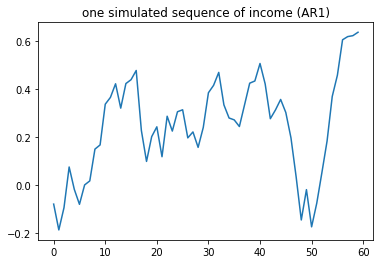

In [107]:
## simulate ar1 data 

plt.subplot(1,1,1)
plt.title('one simulated sequence of income (AR1)')
plt.plot(simulated_data1)

Text(0.5, 1.0, 'Distribution of income over time')

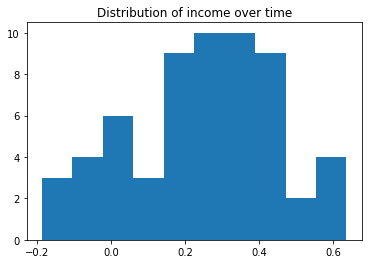

In [108]:
dist = plt.hist(simulated_data1)
plt.title('Distribution of income over time')

In [109]:
simulated_data_pop = one.SimulatePop()

Text(0.5, 1.0, 'Unconditional distribution')

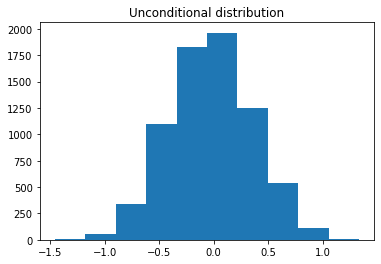

In [110]:
dist_pop = plt.hist(simulated_data_pop.flatten())
plt.title('Unconditional distribution')

### A baseline model of experience-based learning

If each agent knows _perfectly_ the model parameters $\rho$ and $\sigma$, the uncertainty about future income growth is 

\begin{eqnarray}
\begin{split}
Var^*_{i,t}(\Delta y_{i,t+1}) & =  Var^*_{i,t}(y_{i,t+1}- y_{i,t}) \\ 
& =  Var^*_{i,t}((\rho-1)y_{i,t} + \epsilon_{i,t+1}) \\
& = Var^*_{i,t}(\epsilon_{i,t+1}) \\
& = \sigma^2
\end{split}
\end{eqnarray}

The superscript $*$ is the notation for perfect understanding. The first equality follows because both $y_{i,t}$ and the persistent parameter $\rho$ is known by the agent. The second follows because $\sigma^2$ is also known. 

Under _imperfect_ understanding and learning, both $\rho$ and $\sigma^2$ are unknown to agents. Therefore, the agent needs to learn about the parameters from the small panel sample experienced up to that point of the time. We represent the sample estimates of $\rho$ and $\sigma^2$ using $\widehat \rho$ and $\hat{\sigma}^2$. 

\begin{eqnarray}
\begin{split}
\widehat Var_{i,t}(\Delta y_{i,t+1}) & = y_{i,t-1}^2 \widehat{Var}^{\rho}_{i,t} + \hat{\sigma}^2_{i,t}
\end{split}
\end{eqnarray}

The perceived risks of future income growth have two components. The first one comes from the uncertainty about the persistence parameter. The second is based on the estimated risk of a yet-unrealized shock. The first component is non-existent under perfect understanding. Notice that this source of uncertainty is scaled by the squared size of the contemporary income. It implies that the income risks are size-dependent under imperfect understanding. We will return to this point later. And the second component has its perfectly known counterpart under perfect understanding. In general, the estimates $\hat{\sigma}^2_{i,t}$ can be lower or higher than the true risks, but it is an unbiased estimator for the true $\sigma^2$. 

We assume agents learn about the parameters using a least-square rule widely used in the learning literature. The bounded rationality prevents her from adopting any more sophisticated rule that econometricians may consider to be superior to the OLS. (For instance, OLS applied in autocorrelated models induce bias in estimate.) We first consider the case when the agent understands that the income shocks are i.i.d. To put it differently, this is when the agent correctly specify the income model when learning. The least-square estimate of paramters are the following.


\begin{eqnarray}
\hat \rho_{i,t} = (\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y_{j,t-k-1}y_{j,t-k})
\end{eqnarray}

The variance of sample residuls are used for estimating the income volatility $\sigma^2$. 

\begin{eqnarray}
\widehat{\sigma}^2_{i,t} = s^2_{i,t} = \frac{1}{N_{i,t}-1} \sum^{N_{i,t}}_{j=1}\sum^{t-c}_{k=0} \hat e_{j,t-k}^2
\end{eqnarray}

where $N_{i,t}$ is the size of the panel sample available to the agent $i$ at time t. It is equal to $n(t-c)$, the number of people in the sample times the duration of agent $i$'s career. 

Under i.i.d. assumption, the estimated uncertainty about the estimate is 

\begin{eqnarray}
\widehat {Var}^{\rho}_{i,t} = (\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}\widehat{\sigma}^2_{i,t}I_{N_{i,t}}
\end{eqnarray}

Experience-based learning naturally introduces a mechanism for the perceived income risks to be cohort-specific and age-specific. Different generations who have experienced different realizations of the income shocks have different estimates of $Var^{\rho}$ and $\sigma^2$, thus differ in their uncertainty about future income. In the meantime, people at an older age are faced with a larger sample size than younger ones, this will drive the age profile of perceived risks in line with the observation that the perceived risk is lower as one grows older. Also, note that the learning literature has explored a wide variety of assumptions on the gains from learning to decline over time or age. These features can be easily incorporated into my framework. For now, equal weighting of the past experience suffices for the exposition here. 

We can rewrite the perceived risk under correct model specification as the following. 


\begin{eqnarray}
\widehat{Var}_{i,t}(\Delta y_{i,t+1}) = [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}I_{N_{i,t}}y^2_{i,t} + 1] \hat{\sigma}^2_{i,t}
\end{eqnarray}

### Attribution  

Attribution means that agents subjectively form perceptions about the correlation between their own income outcome and others. This opens room for possible model-misspecification about the nature of income shock due to bounded rationality. Although people specify the regression model correctly, they do not necessarily perceive the nature of the income shocks correctly. 

Before introducing the specific mechanism of the attribution bias,  we can generally discuss the property of parameter uncertainty for any general subjective perception of the cross-sectional correlation. Under the least-square learning rule, the perceived uncertainty about the parameter estimate now takes a more general form as below. It is equivalent to accounting for within-time clustering in computing standard errors.

\begin{eqnarray}
\begin{split}
\tilde {Var}^{\rho}_{i,t} & =   (\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}(\sum^{t-c}_{k=0}\tilde \Omega_{t-k})(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}
\end{split}
\end{eqnarray}

where $\tilde \Omega_{t-k}$ is the perceived variance-covariance of income and income shocks within each point of time. 

\begin{eqnarray}
\begin{split}
\tilde \Omega_{t} = \tilde E_{i,t}(Y_{t-1}\epsilon_{t}'\epsilon_{t}Y_{t-1})
\end{split}
\end{eqnarray}

If we assume constant group size $n$ over time and the homoscedasticity, i.e. income risks $\sigma$ do not change over time, given the individual ascribes a subjective correlation coefficient of $\tilde \delta_{\epsilon, i,t}$ across income shocks and a correlation $\tilde \delta_{y, i,t}$ across the levels of income, $\tilde \Omega_{t}$ can be approximated as the following. (See the appendix for derivation) (This is analogous to the cluster-robust standard error by <cite data-cite="cameron2011robust">Cameron et al. (2011)</cite>. But the distinction is that both long-run and short-run correlation are subjective now. ) 


\begin{eqnarray}
\begin{split}
\tilde \Omega_{t} & \approx \tilde \sigma^2_{t} (1+\tilde \delta_{y,i,t}\tilde \delta_{\epsilon,i,t}(n-1)) \sum^{n}_{j=1}y^2_{j,t}
\end{split}
\end{eqnarray}

Therefore, the parameter uncertainty under the subjective attribution takes a following form comparable with that derive for i.i.d. in previous section. 

\begin{eqnarray}
\begin{split}
\tilde {Var}^{\rho}_{i,t} & = (\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}\tilde{\sigma}^2_{t}(1+ \tilde\delta_{i,t}(n-1))
\end{split}
\end{eqnarray}

Where we bundle the two correlation coefficients parameters together as a single parameter of the attribution correlation, which represents the degree of attribution bias. 

\begin{eqnarray}
\tilde \delta_{y,i,t}\tilde \delta_{\epsilon,i,t}\equiv \tilde \delta_{i,t}  
\end{eqnarray}

The subjective attribution is jointly  by two perceived correlation parameters, $\tilde \delta_{\epsilon}$ and $\tilde \delta_y$. They can be more intuively thought as long-run attribution and short-run attribution, respectively, because the former is the perceived correlation in the level of the income and later in the income shocks. The multiplication of two jointly governs the degree to which the agents inflate the past volatility in forming perceptions about future income risks. 

$\tilde \delta_{i,t} = 0$ if the agent $i$ thinks that her income shock or the long-run income is uncorrelated with others ($\tilde \delta_{\epsilon} = 0$ or $\tilde \delta_y = 0$). In contrats, $\tilde \delta_{i,t} = 1$, attaining its maximum value if the agent thinks both her income shock and income is perfectly correlated with others. In general,  $\tilde \delta_{\epsilon,i,t}$ and $\tilde \delta_{y,i,t}$ are not necessarily consistent with the true income process. Since long-run correlation increases with the the short-run correlation, bundling them together as a single parameter is feasible. 


### Attribution bias 

The framework set up above can neatly incorporate the psychological tendency of ascribing bad luck to external causes and good luck to internal ones. The manifesto of the bias in the context is that people asymmetrically assign the subjective correlation $\tilde \delta_{i,t}$ depending on the sign of the recent income change (or the realized shocks).  A positive change in income induces the agent to maintain the independence assumption, while a negative change in income makes the agent interpret the shock to be positively correlated with each other within each point of the time. Assuming the perceived correlation is the same between different people, this is equivalent to saying that the agent's subject attribution leads her to believe that the correlation across agents is $\tilde\delta_{i,t}$. 


\begin{eqnarray}
\begin{split}
\tilde\delta_{i,t} = 0 \quad \textrm{if} \quad \Delta y_{i,t}>0 \\
\tilde\delta_{i,t} = 1 \quad \textrm{if} \quad \Delta y_{i,t}<0
\end{split}
\end{eqnarray}

Here, I let the attribution be contingent on the income change $\Delta y_{i,t}$. An alternative to it can be the forecast errors, $\widehat e_{i,t}$, namely the unexpected income shock to agent $i$ at time $t$. The distinction between the two modeling techniques is indistinguishable in terms of qualitative predictions I will discuss next. 


One can immediately show the following:

\begin{eqnarray}
\tilde {Var}^{\rho}_{i,t} \geq \widehat {Var}^{\rho}_{i,t} \quad \forall \quad \tilde\delta_{i,t} \geq 0
\end{eqnarray}

where the equality holds as a special case when $\tilde\delta_{i,t} = 0$. The left hand side monotonically increases with $\tilde \delta_{i,t}$. 

In the meantime, the estimates of $\sigma^2$ remain the same no matter if the attribution bias arises, both of which are equal to the sample average of regression residuals $s^2$. 


\begin{eqnarray}
\tilde{\sigma}^2_{i,t} = \widehat{\sigma}^2_{i,t}
\end{eqnarray}

Combining both relations above, one can show the perceived risks of an unlucky person is unambiguously higher than that of a lucky one. 

\begin{eqnarray}
\begin{split}
\tilde {Var}_{i,t}(\Delta y_{i,t+1}) & = y_{i,t-1}^2 \tilde{Var}^{\rho}_{i,t} + \tilde{\sigma}^2_{i,t} \\
& = [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}(1+ \tilde\delta_{i,t}(n-1))y^2_{i,t} + 1] \tilde{\sigma}^2\\
& \geq \widehat {Var}_{i,t}(\Delta y_{i,t+1}) 
\end{split}
\end{eqnarray}

where, again, the equality holds without attribution bias, i.e. $\tilde \delta_{i,t} = 0$. One way to rephrase the inequality above is that the unlucky group excessively extrapolates the realized shocks into her perception of risks. There is no distinction between the two groups if there is no attribution bias. 

We have the following predictions about the perceived income risks from the analysis. 

- Higher experienced volatility, measured by $s^2 \equiv \tilde{\sigma}^2_{i,t}$ leads to higher perceived income risks. 
- In the same time, future perceptions of the risks inflate the past volatility by proportionately depending on their subjective attribution. A higher degree of external attribution reflected by a higher $\tilde \delta_{i,t}$ implies a higher inflaiton of past volatility into future. 

- With attribution bias, people project past experienced volatility into perceived risks disproportionately depending on the subjective attribution. A higher perceived attribution to common shocks, a bigger $\tilde \delta_{i,t}$ induces a higher perceived risk. See the comparison between Figure \ref{var_experience_var}. This is different from the scenario without attribution bias.

It is important to note that this difference still arises even if one assumes the underlying shocks are indeed non-independent. Although different types of income shocks have different implications as to which group correctly or mis-specifies the model, it does not alter the distinction between the lucky and unlucky group. To put it bluntly,  the underlying process determines who is over-confident or under-confident. But the lucky group is always more confident than the unlucky group. 

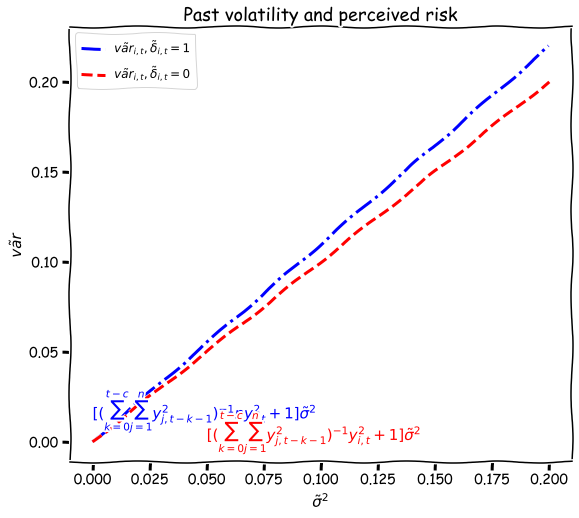

In [87]:
simga2s = np.linspace(0,2*one.sigma,10)
tilde_var_paras = np.empty(10)
hat_var_paras = np.empty(10)
y_now = 0.1


for i,sigma2 in enumerate(simga2s):
    tilde_var_paras[i] = one.PredictVar(y_now = 1,
                                        corr = 1,
                                        sigma2 = sigma2)
    hat_var_paras[i] = one.PredictVar(y_now = 1,
                                      corr = 0,
                                      sigma2 = sigma2)
with plt.xkcd():
    plt.figure(figsize = figsize)
    plt.plot(simga2s,
            tilde_var_paras,
            'b-.',
            lw = 3,
            label =r'$\tilde{var}_{i,t}, \tilde \delta_{i,t} = 1$')
    plt.plot(simga2s,
            hat_var_paras,
            'r--',
            lw = 3,
            label =r'$\tilde{var}_{i,t}, \tilde \delta_{i,t} = 0$')
    plt.xlabel(r'$\tilde \sigma^2$',
               fontsize = fontsize)
    plt.ylabel(r'$\tilde{var}$',
               fontsize = fontsize)
    plt.text(0,0.013,
             r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}ny^2_{i,t} + 1] \tilde{\sigma}^2$',
             fontsize = fontsize, 
             color='blue', 
             horizontalalignment="left")
    plt.text(0.05,0.001,
             r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}y^2_{i,t} + 1] \tilde{\sigma}^2$',
             fontsize = fontsize, 
             color='red', 
             horizontalalignment="left")
    #plt.annotate("x", xy=(px, py), 
    #             xytext=(px-1.3,py+0.5),
    #             color="green",
    #             weight="heavy", 
    #             fontsize= 14,
    #             arrowprops={"facecolor": "lightgreen"})
    plt.grid(True)
    plt.legend(loc = 0,
               fontsize = legendsize)
    plt.title('Past volatility and perceived risk',
             fontsize = titlesize)

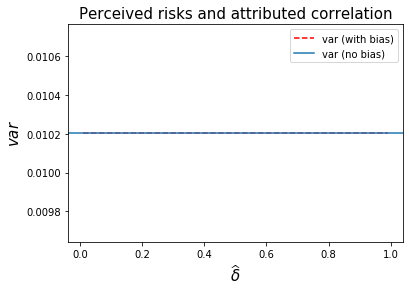

In [10]:
## This is the above chart simulated 
## different attributions and perceived income risks  

times = 10
corrs = np.linspace(0.01,0.99,times)
vars_predict_est = np.empty(times)

for i,corr in enumerate(corrs):
    one.corr = corr
    one.Simulateiid()
    one.shock_type_perceived = 'attribution_biased'
    one.LearnPara(sample = one.simulated_pop,
                 which = 20)
    vars_predict_est[i] = one.var_predict_chg_est

plt.plot(corrs,
        vars_predict_est,
        'r--',
        label = "var (with bias)")
plt.axhline(vars_predict_est[0],
            label = 'var (no bias)')
plt.title('Perceived risks and attributed correlation',
         fontsize = 15)
plt.xlabel(r'$\widehat\delta$',
          fontsize = 15)
plt.ylabel(r'$var$',
          fontsize = 15)
plt.legend(loc = 0)

### Extrapolative attribution bias

The baseline model only lets the sign of the recent income change induce attribution bias, and assumes away the possibility of the attribution bias to depend on the magnitude of the recent changes endogenously. This is reflected in the model assumption that $\tilde \delta_i$ could take either 1 or 0 depending on the sign of the recent income change. We could alternatively allow the attributed correlation $\tilde \delta_i$ to be a function of the $\Delta(y_{i,t})$. This will open the room for income changes of different salience to induce different degrees of attribution bias. 

In order to capture this size-dependent pattern, I choose an attribution function that takes the following form as the following. It does not have to be this function in particular, but its properties suit the purpose here.   

\begin{eqnarray}
\begin{split}
\tilde \delta(\Delta y_{i,t}) = 1- \frac{1}{(1+e^{-\theta \Delta y_{i,t}})}
\end{split}
\end{eqnarray}


Basically, the attribution function is a variant of a logistic function with its function value bounded between $[0,1]$. It takes an s-shape and the parameter $\theta$ governs the steepness of the s-shape around its input value. In the model, $\theta$ is the parameter that governs the degree of the attribution bias. It takes any non-negative value. Although the qualitative pattern induced by the attribution bias stands for any positive $\theta$, letting it be a parameter leaves modelers the room to recover it from subjective risks data. The attribution function under different $\theta$ is shown in Figure \ref{attribution_func_size}. The higher $\theta$ is, the more sensitive the assigned correlation is to the size of the shock, thus inducing a higher dispersion of the perceived correlation between the lucky group and the unlucky group. 

Text(0, 0.5, '$\\hat \\delta_{i,t}$')

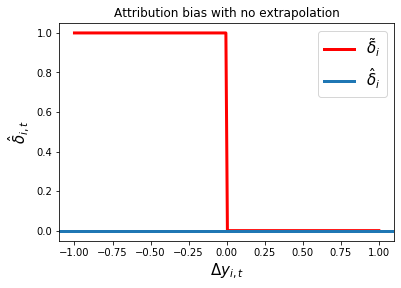

In [11]:
## simple attribution function

chgs = np.linspace(-1,1,200)
corrs = one.extrapolate(chgs,
                       how = 'by_sign')

plt.title('Attribution bias with no extrapolation')
plt.plot(chgs,
         corrs,
         'r-',
         lw = 3,
        label = r'$\tilde \delta_{i}$')
plt.axhline(0,
            lw = 3,
           label =r'$\hat \delta_{i}$')
plt.legend(loc = 0,
           fontsize = 15)
plt.xlabel(r'$\Delta y_{i,t}$',
          fontsize = 15)
plt.ylabel(r'$\hat \delta_{i,t}$',
          fontsize = 15)

Text(0.5, 1.0, 'Attribution function with different degrees of bias')

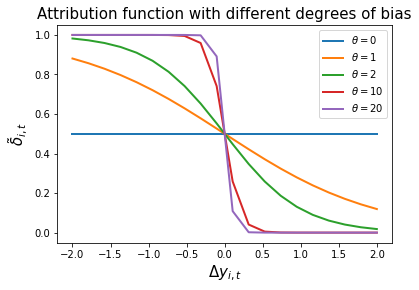

In [12]:
## extrapolative attribution function

chgs = np.linspace(-2,2,20)

thetas = np.array([0,1,2,10,20])

for theta in thetas:
    one.theta = theta
    corrs = one.extrapolate(chgs)
    plt.plot(chgs,
             corrs,
             lw = 2,
             label = r'$\theta =$'+str(theta))
    #plt.axhline(0,
    #           label =r'$\hat \delta_{i}$')
    plt.legend(loc = 0,
              fontsize = 10)
plt.xlabel(r'$\Delta y_{i,t}$',
           fontsize = 15)
plt.ylabel(r'$\tilde \delta_{i,t}$',
           fontsize = 15)
plt.title('Attribution function with different degrees of bias',
         fontsize = 15)

In [13]:
## for iid
"""
## Estimate the model with the correctly specified model of i.i.d shock
one.shock_type_perceived = 'iid'
coeffs_est_iid,coef_vars_est_iid,sigma2s_est_iid,var_predict_chg_est_iid = one.LearnParafromExperience()
var_predict_chg_est_iid_mean = np.nanmean(var_predict_chg_est_iid)

est_iid = {'coef_est':np.nanmean(coeffs_est_iid),
          'coef_var_est':np.nanmean(coef_vars_est_iid),
          'sigma2s_est':np.nanmean(sigma2s_est_iid),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_iid)}

## for cluster 
one.shock_type_perceived = 'cluster'
coeffs_est_cl,coef_vars_est_cl,sigma2s_est_cl,var_predict_chg_est_cl = one.LearnParafromExperience()


est_cl = {'coef_est':np.nanmean(coeffs_est_cl),
          'coef_var_est':np.nanmean(coef_vars_est_cl),
          'sigma2s_est':np.nanmean(sigma2s_est_cl),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_cl)}

## for serial_correlate 
one.shock_type_perceived = 'serial_correlate'
coeffs_est_sc,coef_vars_est_sc,sigma2s_est_sc,var_predict_chg_est_sc = one.LearnParafromExperience()

est_sc = {'coef_est':np.nanmean(coeffs_est_sc),
          'coef_var_est':np.nanmean(coef_vars_est_sc),
          'sigma2s_est':np.nanmean(sigma2s_est_sc),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_sc)}

## for attribution biased

one.shock_type_perceived = 'attribution_biased'
coeffs_est_ab,coef_vars_est_ab,sigma2s_est_ab,var_predict_chg_est_ab = one.LearnParafromExperience()

est_ab = {'coef_est':np.nanmean(coeffs_est_ab),
          'coef_var_est':np.nanmean(coef_vars_est_ab),
          'sigma2s_est':np.nanmean(sigma2s_est_ab),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_ab)}


## for attribution biased by size 

one.shock_type_perceived = 'extrapolative_attribution_biased'
coeffs_est_eab,coef_vars_est_eab,sigma2s_est_eab,var_predict_chg_est_eab = one.LearnParafromExperience()

est_eab = {'coef_est':np.nanmean(coeffs_est_eab),
          'coef_var_est':np.nanmean(coef_vars_est_eab),
          'sigma2s_est':np.nanmean(sigma2s_est_eab),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_eab)}

idx = ['iid','cluster','serial correlation','attribution biased','ex_attribution biased']

ests = pd.DataFrame.from_dict([est_iid, 
                               est_cl,
                               est_sc,
                               est_ab,
                              est_eab])
ests.index = idx
"""

"\n## Estimate the model with the correctly specified model of i.i.d shock\none.shock_type_perceived = 'iid'\ncoeffs_est_iid,coef_vars_est_iid,sigma2s_est_iid,var_predict_chg_est_iid = one.LearnParafromExperience()\nvar_predict_chg_est_iid_mean = np.nanmean(var_predict_chg_est_iid)\n\nest_iid = {'coef_est':np.nanmean(coeffs_est_iid),\n          'coef_var_est':np.nanmean(coef_vars_est_iid),\n          'sigma2s_est':np.nanmean(sigma2s_est_iid),\n          'var_predict_chg_est':np.nanmean(var_predict_chg_est_iid)}\n\n## for cluster \none.shock_type_perceived = 'cluster'\ncoeffs_est_cl,coef_vars_est_cl,sigma2s_est_cl,var_predict_chg_est_cl = one.LearnParafromExperience()\n\n\nest_cl = {'coef_est':np.nanmean(coeffs_est_cl),\n          'coef_var_est':np.nanmean(coef_vars_est_cl),\n          'sigma2s_est':np.nanmean(sigma2s_est_cl),\n          'var_predict_chg_est':np.nanmean(var_predict_chg_est_cl)}\n\n## for serial_correlate \none.shock_type_perceived = 'serial_correlate'\ncoeffs_est_sc,coe

In [14]:
#ests

### Experienced volatility and perceived risk

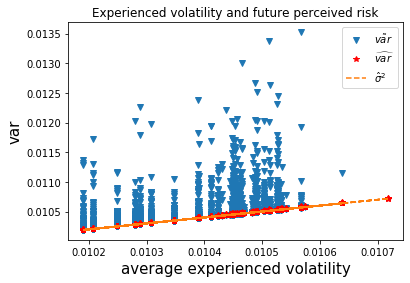

In [15]:
## simulate a historical sample populated by agents at different ages 

## attribution bias 
one.shock_type_perceived = 'iid' #extrapolative_attribution_biased
coeffs_est_iid,coef_vars_est_iid,sigma2s_est_iid,var_predict_chg_est_iid = one.LearnParafromExperience()

ages = one.ages_pop_sim.flatten()
sigma2s = sigma2s_est_iid.flatten()
coef_vars_iid = coef_vars_est_iid.flatten()
vars_predict_chg_iid = var_predict_chg_est_iid.flatten()
av_past = one.av_past.flatten()
recent = one.recent.flatten()

## attribution bias 

one.shock_type_perceived = 'extrapolative_attribution_biased' #extrapolative_attribution_biased
coeffs_est_ab,coef_vars_est_ab,sigma2s_est_ab,var_predict_chg_est_ab = one.LearnParafromExperience()
vars_predict_chg_ab = var_predict_chg_est_ab.flatten()
coef_vars_est_ab = coef_vars_est_ab.flatten()

## average experienced volatility and the perceived income risk

plt.plot(sigma2s,
         vars_predict_chg_ab,'v',
         label = r'$\tilde{var}$')

plt.plot(sigma2s,
         vars_predict_chg_iid,'r*',
         label = r'$\widehat{var}$')

plt.plot(sigma2s,
         sigma2s,'--',
         label = r'$\hat \sigma^2$')

#plt.axhline(one.var_predict_chg,
#            color ='red',
#            label =r'$\sigma^2$')

plt.title('Experienced volatility and future perceived risk')
plt.xlabel('average experienced volatility',
           fontsize = 15)
plt.ylabel('var',fontsize = 15)
plt.legend(loc = 0)

The figure illustrates the correlation between individual's experienced volatility and future perceived income risks. Blue stars represent the scenario without attribution bias, while the orange dots represent perceived risks under attribution bias. 

We can see individuals that have had bad income realizations extrapolate the average size of past shocks into future income risks, even though the past income shocks are the best estimate of future income risks according to the underlying model. 

### Current income and perceived risks 

How do perceived risks depend on the current income level of $y_{i,t}$? Since the recent income changes $\Delta y_{i,t}$ triggers asymmetric attribution, the perceived risks depend on the current level of income beyond the past-dependence of future income on current income that is embodied in the AR(1) process. In particular, $\widehat{Var}^\rho_{i,t}$ does not depend on $\Delta y_{i,t}$ while $\tilde{Var}^\rho_{i,t}$ does and is always greater than the former as a positive, it will amplify the loading of the current level of income into perceived risks about future income. This generates a U-shaped perceived income profile depending on current level income.  

Figure \ref{var_experience_income} plots the simulated correlation between $y_{i,t}$ and perceived income risks with/without attribution bias. In the former scenario, perceived risks only mildly change with current income and the entire income profile of perceived risk is approximately flat. In the latter scenario, in contrast, perceived risks exhibit a clear U-shape across the income distribution. People sitting at both ends of the income distribution have high perceived risks than ones in the middle. The non-monotonic of the income profile arise due to the combined effects directly from $y_{i,t}$ and indirectly via its impact on $\tilde Var^{\rho}$. The former effect is symmetric around the long-run average of income (zero here). Deviations from the long-run mean on both sides lead to higher perceived risk. The latter monotonically decreases with current income because higher income level is associated with a more positive income change recently. The two effects combined create a U-shaped pattern.

A subtle but interesting point is that the U-shape is skewed toward left, meaning perceived risks decrease with the income over the most part of the income distribution before the pattern reverses. More intuitively, it means that although low and high income perceived risks to be higher because of its deviation from the its long-run mean. This force is muted for the high income group because they have a lower peceived risks due to the attribution bias.  

In [ ]:
## model plot
y_nows = np.linspace(-2,2,10)
tilde_vars = np.empty(10)
hat_vars = np.empty(10)
hat_vars_special = np.empty(10)
sigma2 = one.sigma**2

for i,y_now in enumerate(y_nows):
    tilde_vars[i] = one.PredictVar(y_now = y_now,
                                  corr = 1,
                                  sigma2 = sigma2)
    hat_vars[i] = one.PredictVar(y_now = y_now,
                                corr = 0,
                                sigma2 = sigma2)
    hat_vars_special[i] = one.PredictVar(y_now = 0,
                                         corr = 0,
                                         sigma2 = sigma2)
with plt.xkcd():
    plt.figure(figsize = figsize)
    plt.plot(y_nows,
            tilde_vars,
            'b-.',
            lw = 3,
            label =r'$\tilde{var}_{i,t}, \tilde \delta_{i,t} = 1$')
    plt.plot(y_nows,
            hat_vars,
            'r--',
            lw = 3,
            label =r'$\tilde{var}_{i,t}, \tilde \delta_{i,t} = 0$')
    plt.plot(y_nows,
            hat_vars_special,
            'g-',
            lw = 3,
            label =r'$\tilde{sigma}^2$')
    plt.axvline(0,
                lw = 3,
               label = r'$E(y)$')
    plt.xlabel(r'$y_{i,t}$',
               fontsize = fontsize)
    plt.ylabel(r'$\tilde{var}$',
               fontsize = fontsize)
    #plt.text(0,0.013,
    #         r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}ny^2_{i,t} + 1] \tilde{\sigma}^2$',
    #         fontsize = fontsize, 
    #         color='blue', 
    #         horizontalalignment="left")
    #plt.text(0,0.01,
    #         r'$ [(\sum^{t-c}_{k=0}\sum^{n}_{j=1}y^2_{j,t-k-1})^{-1}y^2_{i,t} + 1] \tilde{\sigma}^2$',
    #         fontsize = fontsize, 
    #         color='red', 
    #         horizontalalignment="left")
    plt.xticks([])
    plt.yticks([])
    #plt.annotate("x", xy=(px, py), 
    #             xytext=(px-1.3,py+0.5),
    #             color="green",
    #             weight="heavy", 
    #             fontsize= 14,
    #             arrowprops={"facecolor": "lightgreen"})
    plt.grid(True)
    plt.legend(loc = 1,
               fontsize = legendsize)
    plt.title('Current income and perceived risk',
             fontsize = titlesize)

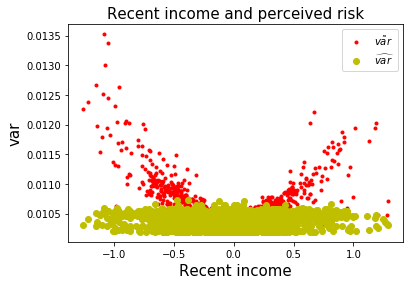

In [28]:
## simulation plot

plt.plot(recent,
         vars_predict_chg_ab,'r.',
         label = r'$\tilde{var}$')
plt.plot(recent,
         vars_predict_chg_iid,'yo',
         label = r'$\widehat{var}$')
plt.title('Recent income and perceived risk',
         fontsize = 15)
plt.xlabel('Recent income',
           fontsize = 15)
plt.ylabel('var',fontsize = 15)
plt.legend(loc = 0)

### Age and perceived risks

In [18]:
#plt.plot(one.ages_pop_sim[:,35],
#         var_predict_chg_est1[:,35],'*')
#plt.title('Perceived risks by age at a given time')
#plt.xlabel('age',fontsize = 15)
#plt.ylabel('var',fontsize = 15)

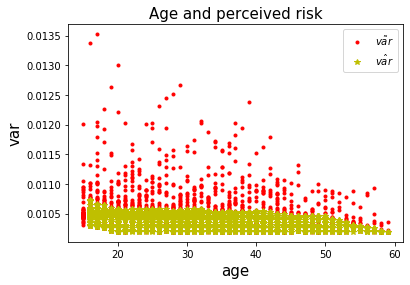

In [19]:
plt.plot(ages,vars_predict_chg_ab,
         'r.',
        label =r'$\tilde{var}$')
plt.plot(ages,vars_predict_chg_iid,
         'y*',
        label =r'$\hat{var}$')
plt.title('Age and perceived risk',
         fontsize = 15)
plt.xlabel('age',fontsize = 15)
plt.ylabel('var',fontsize = 15)
plt.legend(loc = 0)

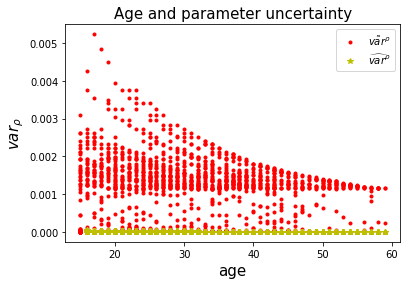

In [20]:
plt.plot(ages,
         coef_vars_est_ab,
         'r.',
        label = r'$\tilde{var}^{\rho}$')
plt.plot(ages,
         coef_vars_iid,
         'y*',
         label = r'$\widehat{var}^{\rho}$')
plt.title('Age and parameter uncertainty',
         fontsize = 15)
plt.xlabel('age',fontsize = 15)
plt.ylabel(r'$var_\rho$',fontsize = 15)
plt.legend(loc = 0)

In [21]:
#plt.plot(ages,sigma2s,'*')
#plt.xlabel('age',fontsize = 15)
#plt.ylabel(r'$\hat \sigma^2$',fontsize = 15)

## Aggregate risk

Previously, I assume the underlying shock is i.i.d. This section considers the implication of the attribution bias in the presence of both aggregate and idiosyncratic risks. This can be modeled by assuming that the shocks to individuals' income are positively correlated with each other at each point of the time. Denoting $\delta>0$ as the true cross-sectional correlation of income shocks, the conditional variance-covariance of income shocks within each period is the following. 


\begin{eqnarray}
\begin{split}
E(\epsilon_{t}'\epsilon_{t}|Y_{t-1}) = \Sigma^2 = \sigma^2\Omega \quad \forall t  
\end{split}
\end{eqnarray}

where $\Omega$ takes one in its diagonal and $\delta$ in off-diagonal.  

The learning process and the attribution bias all stay the same as before. Individuals specify their subjective structure of the shocks depending on the sign and size of their own experienced income changes. By the same mechanism elaborated above, a lucky person has lower perceived risks than her unlucky peer at any point of the time. This distinction between the two group stays the same even if the underlying income shocks are indeed correlated. 

What's new in the presence of aggregate risks lies in the behaviors of average perceived risks, because there is an aggregate shock that drives the comovement of the income shocks affecting individuals. Compared to the environment with pure idiosyncratic risks, there is no longer an approximately equal fraction of lucky and unlucky agents at a given time. Instead, the relative fraction of each group depends on the recently realized aggregate shock. If the aggregate shock is positive, more people have experienced good luck and may, therefore, underestimate the correlation (a smaller $\tilde \delta$). This drives down the average perceived income risks among the population. If the aggregate shock is negative, more people have just experienced income decrease thus arriving at a higher perceived income uncertainty. 

This naturally leads to a counter-cyclical pattern of the average perceived risks in the economy. The interplay of aggregate risks and attribution bias adds cyclical movements of the average perceived risks. The two conditions are both necessary to generate this pattern. Without the aggregate risk, both income shocks and perceived income shocks are purely idiosyncratic and they are averaged out in the aggregate level. Without attribution bias, agents symmetrically process experiences when forming future risk perceptions.

Figure \ref{average_chg_var_agg} illustrates the first point. The scatter plots showcase the correlation between average income changes across population and average perceive risks under purely idiosyncratic risks and aggregate risks. The negative correlation with aggregate risks illustrate the counter-cylical perceived risks. There is no such a correlation under purely idiosyncratic risks. Figure \ref{average_chg_var_ab} testifies the second point. It plots the same correlation with and without attribution bias when the aggregate risk exists. Attribution bias brings about the asymmetry not seen when the bias is absent. 

In [23]:
## plot average past income changes and perceived risks with aggregate risks

one.shock_type = 'correlated'  ## reset the true model to be with aggregate the risks
one.SimulatePop()


one.shock_type_perceived = 'iid' #extrapolative_attribution_biased
coeffs_est_iid_ag,coef_vars_est_iid_ag,sigma2s_est_iid_ag,var_predict_chg_est_iid_ag = one.LearnParafromExperience()

##  cross-sectional average
vars_predict_chg_iid_av = np.nanmean(var_predict_chg_est_iid_ag,axis = 0)
changes_iid_ag_av =  np.nanmean(one.changes,axis = 0)  ## same for the below 

one.shock_type_perceived = 'extrapolative_attribution_biased' #extrapolative_attribution_biased
coeffs_est_eab_ag,coef_vars_est_eab_ag,sigma2s_est_eab_ag,var_predict_chg_est_eab_ag = one.LearnParafromExperience()

##  cross-sectional average
vars_predict_chg_eab_av = np.nanmean(var_predict_chg_est_eab_ag,axis = 0)
changes_eab_ag_av = np.nanmean(one.changes,axis = 0)

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


Text(0.5, 1.0, 'With attribution bias')

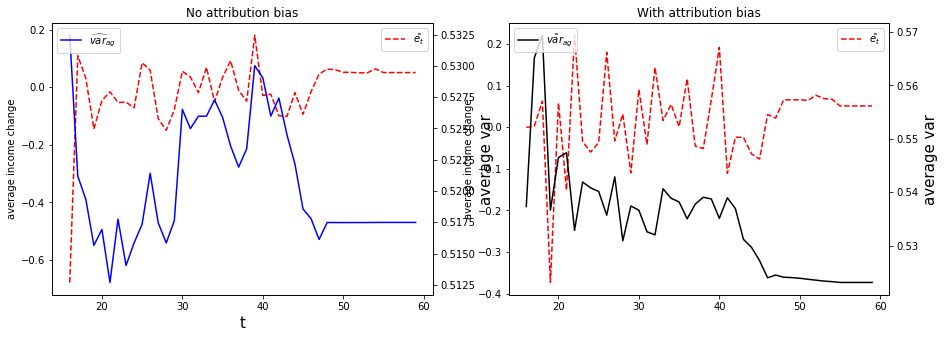

In [24]:
## plot
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax2 = ax[0].twinx()
ax[0].plot(changes_iid_ag_av,
       'r--',
        label = r'$\tilde{e_{t}}$')
ax2.plot(vars_predict_chg_iid_av,
         'b-',
         label = r'$\widehat{var}_{ag}$')
ax[0].set_xlabel('t',
           fontsize = 15)
ax[0].set_ylabel('average income change')
ax2.set_ylabel('average var',fontsize = 15)
ax[0].legend(loc = 1)
ax2.legend(loc = 2)
ax[0].set_title('No attribution bias')

ax3 = ax[1].twinx()
ax[1].plot(changes_eab_ag_av,
       'r--',
        label = r'$\tilde{e_{t}}$')
ax3.plot(vars_predict_chg_eab_av,
         'k-',
         label = r'$\tilde{var}_{ag}$')
ax[1].set_xlabel('t',
           fontsize = 15)
ax[1].set_ylabel('average income change')
ax3.set_ylabel('average var',fontsize = 15)
ax[1].legend(loc = 1)
ax3.legend(loc = 2)
ax[1].set_title('With attribution bias')

In [25]:
## aggregate risks versus indiosyncratic risks we

### only idiosyncratic risks
one.shock_type_perceived = 'extrapolative_attribution_biased' #extrapolative_attribution_biased common for both 

## shocks take either iid or aggregate  
one.shock_type = 'iid'  ## reset the true model to be with aggregate the risks
one.SimulatePop()

coeffs_est_eab_id,coef_vars_est_eab_id,sigma2s_est_eab_id,var_predict_chg_est_eab_id = one.LearnParafromExperience()

##  cross-sectional average
vars_predict_chg_eab_id_av = np.nanmean(var_predict_chg_est_eab_id,axis = 0)
changes_eab_id_av =  np.nanmean(one.changes,axis = 0)

### aggregate risk
one.shock_type = 'correlated'  ## reset the true model to be with aggregate the risks
one.SimulatePop()

coeffs_est_eab_ag,coef_vars_est_eab_ag,sigma2s_est_eab_ag,var_predict_chg_est_eab_ag = one.LearnParafromExperience()

##  cross-sectional average
vars_predict_chg_eab_av = np.nanmean(var_predict_chg_est_eab_ag,axis = 0)
changes_eab_ag_av =  np.nanmean(one.changes,axis = 0)

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: overflow encountered in exp
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


Text(0.5, 1.0, 'Aggregate risks with attribution bias')

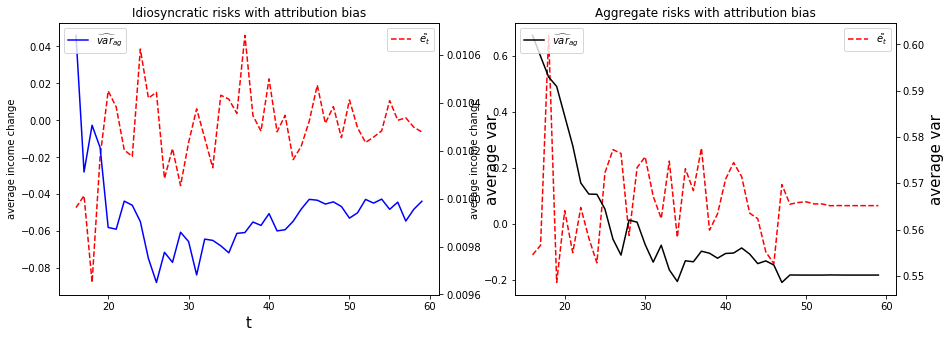

In [26]:
## plot idiosyncratic risks and aggregate risks 
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax2 = ax[0].twinx()
ax[0].plot(changes_eab_id_av,
       'r--',
        label = r'$\tilde{e_{t}}$')
ax2.plot(vars_predict_chg_eab_id_av,
         'b-',
         label = r'$\widehat{var}_{ag}$')
ax[0].set_xlabel('t',
           fontsize = 15)
ax[0].set_ylabel('average income change')
ax2.set_ylabel('average var',fontsize = 15)
ax[0].legend(loc = 1)
ax2.legend(loc = 2)
ax[0].set_title('Idiosyncratic risks with attribution bias')

ax3 = ax[1].twinx()
ax[1].plot(changes_eab_ag_av,
       'r--',
        label = r'$\tilde{e_{t}}$')
ax3.plot(vars_predict_chg_eab_av,
         'k-',
         label = r'$\widehat{var}_{ag}$')
ax[1].set_ylabel('average income change')
ax3.set_ylabel('average var',fontsize = 15)
ax[1].set_xlabel('t',
           fontsize = 15)
ax[1].legend(loc = 1)
ax3.legend(loc = 2)
ax[1].set_title('Aggregate risks with attribution bias')